# Windows with Forecast

Tries to generate windows with forecasts (multilabel, or more than one label as output) .

In [1]:
import sys
sys.path.append('../..')

from model_compra_comigo.data_handler.data_simulator import DataSimulator
from model_compra_comigo.data_handler.data_handler import DataHandler
import tensorflow as tf
from numpy import arange
import tensorflow_datasets as tfds


2023-07-05 00:13:31.088874: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 00:13:31.113838: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 00:13:31.114354: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 00:13:31.672133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_simulator = DataSimulator()
data_handler = DataHandler()


## Generate a Dataset

{"levelname": "WARNING", "asctime": "2023-07-05 00:13:32,643", "filename": "legend.py", "funcName": "_parse_legend_args", "lineno": 1323, "message": "No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument."}


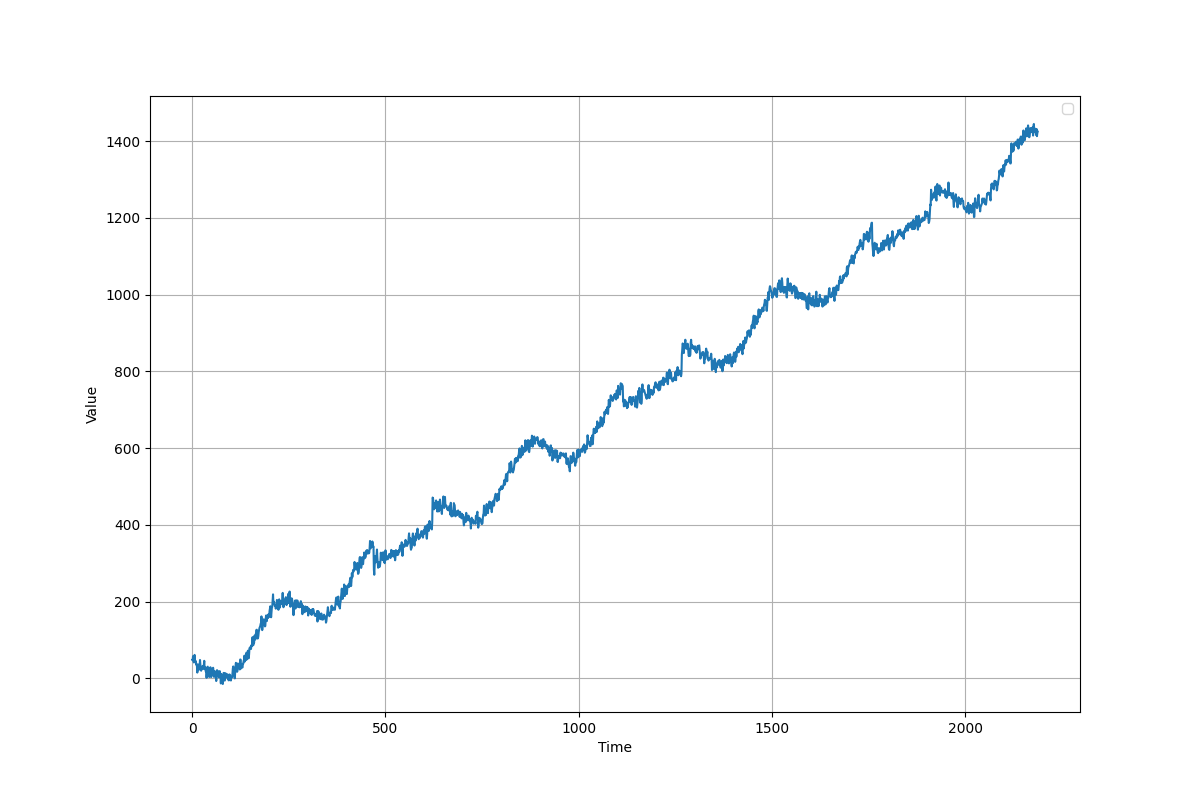

In [3]:
data_simulator = DataSimulator()
time_range = 365*6
split = 365
time_data = arange(time_range)

series, parameters = data_simulator.generate(
    time_range = time_range,
)

labels=[(f"trend_slope = {parameters['trend_slope']}\n"
         f"seasonality_period = {parameters['seasonality_period']}\n"
         f"seasonality_amplitude = {parameters['seasonality_amplitude']}\n"
         f"seasonality_phase = {parameters['seasonality_phase']}\n"
         f"seasonality_time_threshold = {parameters['seasonality_time_threshold']}\n"
         f"seasonality_ncos = {parameters['seasonality_ncos']}\n"
         f"seasonality_nexp = {parameters['seasonality_nexp']}\n"
         f"noise_scaling_factor = {parameters['noise_scaling_factor']}\n"
         f"autocorrelation_amplitude = {parameters['autocorrelation_amplitude']}\n"
         f"autocorrelation_phi = {parameters['autocorrelation_phi']}"
        )]

data_handler.plot_series(
    time=time_data,
    series=series,
    labels=labels
)


## Creates Windowed Dataset with N forecasts

In [4]:
window_size = 30
nforecast = 3
batch_size = len(series)
shuffle_buffer_size = 1000
shuffle = False

In [5]:
data = data_handler.generate_windowed_dataset(
    data=series,
    window_size=window_size,
    nforecast=nforecast,
    batch_size=batch_size,
    shuffle_buffer_size=shuffle_buffer_size,
    shuffle=shuffle
)


In [7]:
data_X, data_y = data_handler.convert_tensorflow_dataset_to_numpy(
    dataset=data
)


2023-07-05 00:15:35.599756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2190]
	 [[{{node Placeholder/_0}}]]
2023-07-05 00:15:35.599973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2190]
	 [[{{node Placeholder/_0}}]]


In [8]:
len(data_X[0]), len(data_X[0][1]), data_X[0][:2], data_X[0][1][0]


(2158,
 30,
 array([[48.34754615, 46.92616211, 57.90681887, 56.66605828, 41.56460187,
         49.90931441, 61.13114119, 48.19090451, 42.06267965, 44.72252581,
         35.80375831, 38.59914712, 33.15291489, 15.07810254, 21.23649828,
         28.41101534, 31.31171795, 36.07740906, 22.8733516 , 32.28208034,
         47.86608044, 35.29929813, 29.14055567, 19.96327122, 29.66261127,
         28.48308498, 25.01370072, 32.19581875, 25.16054246, 25.28110376],
        [46.92616211, 57.90681887, 56.66605828, 41.56460187, 49.90931441,
         61.13114119, 48.19090451, 42.06267965, 44.72252581, 35.80375831,
         38.59914712, 33.15291489, 15.07810254, 21.23649828, 28.41101534,
         31.31171795, 36.07740906, 22.8733516 , 32.28208034, 47.86608044,
         35.29929813, 29.14055567, 19.96327122, 29.66261127, 28.48308498,
         25.01370072, 32.19581875, 25.16054246, 25.28110376, 34.56084563]]),
 46.92616211011719)

In [9]:
len(data_y[0]), len(data_y[0][1]), data_y[0][:5]


(2158,
 3,
 array([[34.56084563, 45.65291613, 24.41286464],
        [45.65291613, 24.41286464, 23.63442245],
        [24.41286464, 23.63442245, 28.17588829],
        [23.63442245, 28.17588829, 17.61826759],
        [28.17588829, 17.61826759, 17.45484546]]))

### Reconstruct Series from X

In [10]:
series_reconstructed_from_X = []
for i, x in enumerate(data_X[0]):
    series_reconstructed_from_X.append(data_X[0][i][0])
len(series_reconstructed_from_X), len(series)

(2158, 2190)

{"levelname": "WARNING", "asctime": "2023-07-05 00:15:44,939", "filename": "legend.py", "funcName": "_parse_legend_args", "lineno": 1323, "message": "No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument."}


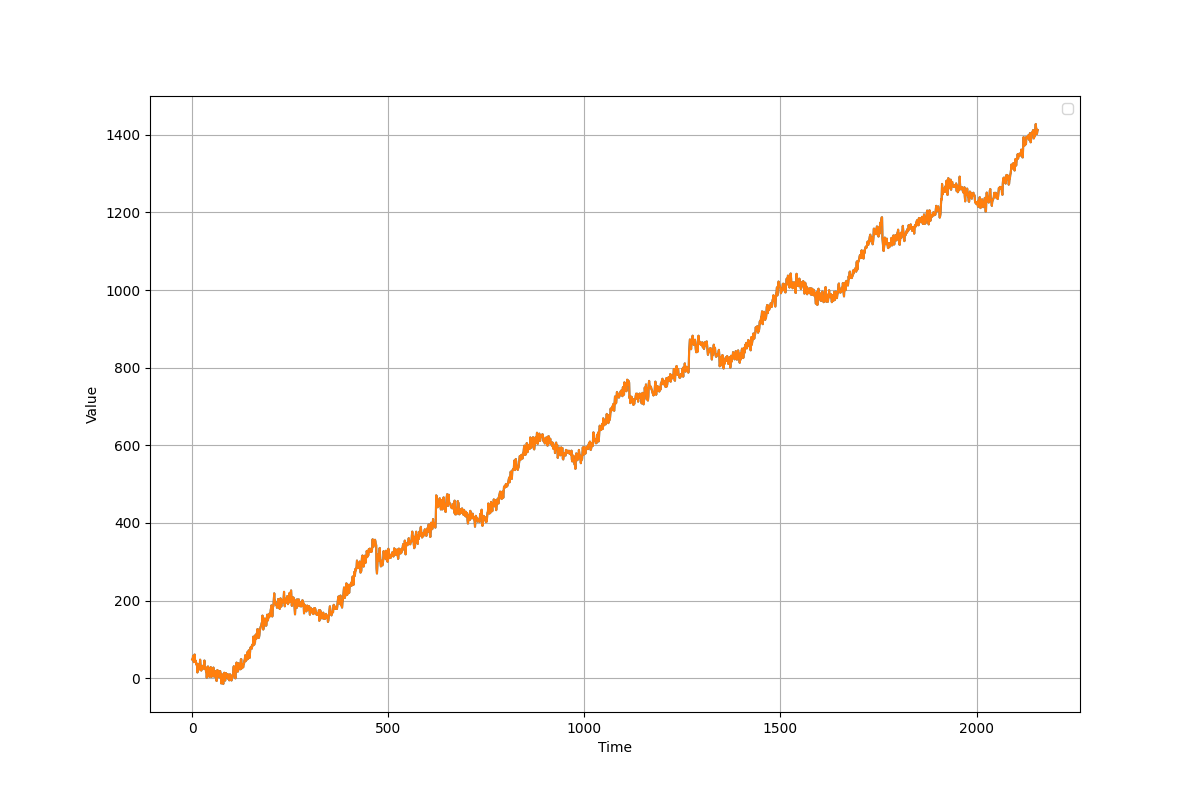

In [11]:
size_reconstructed = len(series_reconstructed_from_X)
data_handler.plot_series(
    time=time_data[:size_reconstructed],
    series=(series_reconstructed_from_X, series[:size_reconstructed]),
    labels=labels
)


### Reconstruct Series from y

In [12]:
series_reconstructed_from_y = []
for i, x in enumerate(data_y[0]):
    series_reconstructed_from_y.append(data_y[0][i][0])
len(series_reconstructed_from_y), len(series)

(2158, 2190)

{"levelname": "WARNING", "asctime": "2023-07-05 00:15:47,849", "filename": "legend.py", "funcName": "_parse_legend_args", "lineno": 1323, "message": "No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument."}


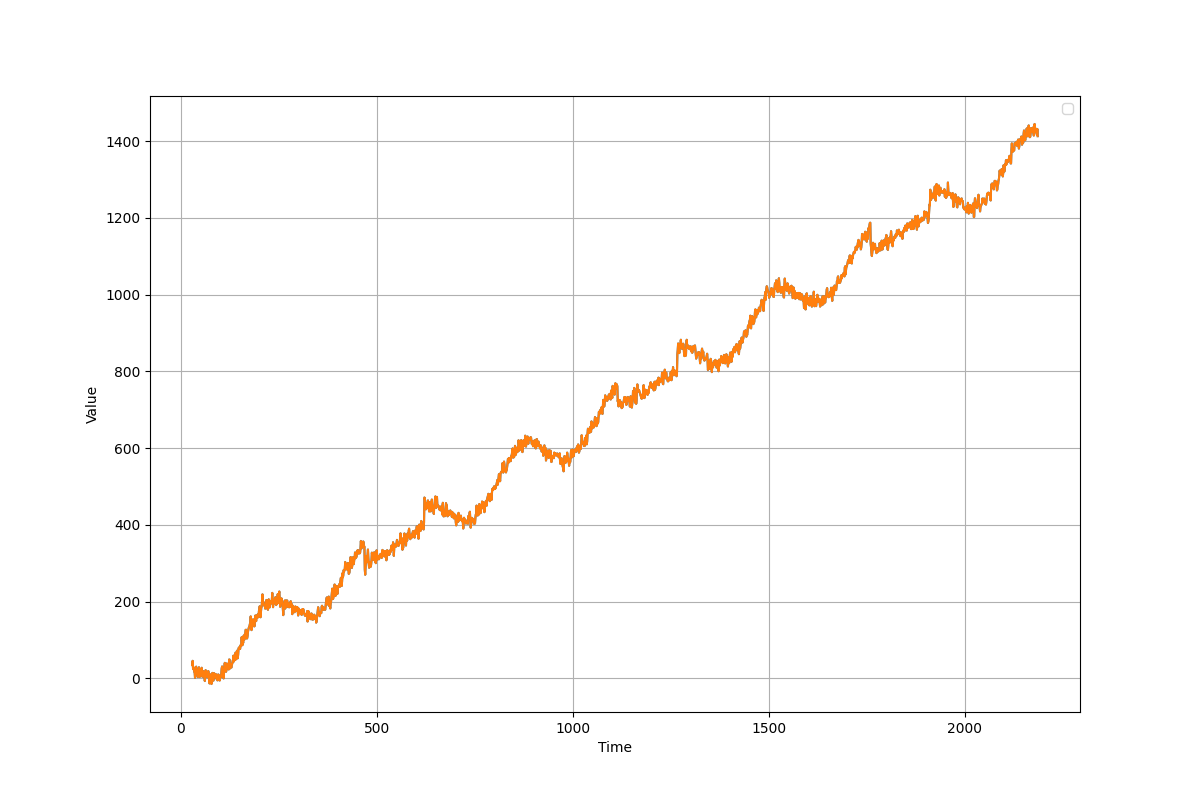

In [13]:
size_reconstructed = len(series_reconstructed_from_y)
data_handler.plot_series(
    time=time_data[window_size:size_reconstructed+window_size],
    series=(series_reconstructed_from_y, series[window_size:size_reconstructed+window_size]),
    labels=labels
)
